<a href="https://colab.research.google.com/github/YoshiakiAsahara/colob-python/blob/main/%E3%82%A4%E3%83%B3%E3%82%BF%E3%83%BC%E3%83%B3%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データサイエンス100本ノック（構造化データ加工編） - Python

## はじめに
- 初めに以下のセルを実行してください
- 必要なライブラリのインポートとデータベース（PostgreSQL）からのデータ読み込みを行います
- pandas等、利用が想定されるライブラリは以下セルでインポートしています
- その他利用したいライブラリがあれば適宜インストールしてください（"!pip install ライブラリ名"でインストールも可能）
- 処理は複数回に分けても構いません
- 名前、住所等はダミーデータであり、実在するものではありません

In [ ]:
import os
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import math
from sqlalchemy import create_engine
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from imblearn.under_sampling import RandomUnderSampler


if 'PG_PORT' in os.environ:

    host = 'db'
    port = os.environ['PG_PORT']
    database = os.environ['PG_DATABASE']
    user = os.environ['PG_USER']
    password = os.environ['PG_PASSWORD']

    # pd.read_sql用のコネクタ
    conn = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")

    df_customer = pd.read_sql(sql='select * from customer', con=conn)
    df_category = pd.read_sql(sql='select * from category', con=conn)
    df_product = pd.read_sql(sql='select * from product', con=conn)
    df_receipt = pd.read_sql(sql='select * from receipt', con=conn)
    df_store = pd.read_sql(sql='select * from store', con=conn)
    df_geocode = pd.read_sql(sql='select * from geocode', con=conn)

else:
    if not os.path.exists('../data/'):
        !git clone https://github.com/The-Japan-DataScientist-Society/100knocks-preprocess
        os.chdir('100knocks-preprocess/docker/work/answer')

    dtype = {
        'customer_id': str,
        'gender_cd': str,
        'postal_cd': str,
        'application_store_cd': str,
        'status_cd': str,
        'category_major_cd': str,
        'category_medium_cd': str,
        'category_small_cd': str,
        'product_cd': str,
        'store_cd': str,
        'prefecture_cd': str,
        'tel_no': str,
        'postal_cd': str,
        'street': str
    }

    df_customer = pd.read_csv("../data/customer.csv", dtype=dtype)
    df_category = pd.read_csv("../data/category.csv", dtype=dtype)
    df_product = pd.read_csv("../data/product.csv", dtype=dtype)
    df_receipt = pd.read_csv("../data/receipt.csv", dtype=dtype)
    df_store = pd.read_csv("../data/store.csv", dtype=dtype)
    df_geocode = pd.read_csv("../data/geocode.csv", dtype=dtype)


Cloning into '100knocks-preprocess'...
remote: Enumerating objects: 1908, done.
remote: Counting objects: 100% (703/703), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 1908 (delta 587), reused 591 (delta 535), pack-reused 1205
Receiving objects: 100% (1908/1908), 20.97 MiB | 17.28 MiB/s, done.
Resolving deltas: 100% (1068/1068), done.


# 演習問題

---
> P-001: レシート明細データ（df_receipt）から全項目の先頭10件を表示し、どのようなデータを保有しているか目視で確認せよ。

In [ ]:
df=df_receipt
df.head(10)

,sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
0,20181103,1541203200,S14006,112,1,CS006214000001,P070305012,1,158
1,20181118,1542499200,S13008,1132,2,CS008415000097,P070701017,1,81
2,20170712,1499817600,S14028,1102,1,CS028414000014,P060101005,1,170
3,20190205,1549324800,S14042,1132,1,ZZ000000000000,P050301001,1,25
4,20180821,1534809600,S14025,1102,2,CS025415000050,P060102007,1,90
5,20190605,1559692800,S13003,1112,1,CS003515000195,P050102002,1,138
6,20181205,1543968000,S14024,1102,2,CS024514000042,P080101005,1,30
7,20190922,1569110400,S14040,1102,1,CS040415000178,P070501004,1,128
8,20170504,1493856000,S13020,1112,2,ZZ000000000000,P071302010,1,770
9,20191010,1570665600,S14027,1102,1,CS027514000015,P071101003,1,680


---
> P-002: レシート明細データ（df_receipt）から売上年月日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上金額（amount）の順に列を指定し、10件表示せよ。

In [ ]:
df[['sales_ymd', 'customer_id', 'product_cd', 'amount']].head(10)

,sales_ymd,customer_id,product_cd,amount
0,20181103,CS006214000001,P070305012,158
1,20181118,CS008415000097,P070701017,81
2,20170712,CS028414000014,P060101005,170
3,20190205,ZZ000000000000,P050301001,25
4,20180821,CS025415000050,P060102007,90
5,20190605,CS003515000195,P050102002,138
6,20181205,CS024514000042,P080101005,30
7,20190922,CS040415000178,P070501004,128
8,20170504,ZZ000000000000,P071302010,770
9,20191010,CS027514000015,P071101003,680


---
> P-003: レシート明細データ（df_receipt）から売上年月日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上金額（amount）の順に列を指定し、10件表示せよ。ただし、sales_ymdをsales_dateに項目名を変更して抽出すること。

In [ ]:
df = df.rename(columns = {'sales_ymd':'sales_date'})
print(df[['sales_date', 'customer_id', 'product_cd', 'amount']].head(10))
df = df.rename(columns = {'sales_date':'sales_ymd'})

   sales_date     customer_id  product_cd  amount
0    20181103  CS006214000001  P070305012     158
1    20181118  CS008415000097  P070701017      81
2    20170712  CS028414000014  P060101005     170
3    20190205  ZZ000000000000  P050301001      25
4    20180821  CS025415000050  P060102007      90
5    20190605  CS003515000195  P050102002     138
6    20181205  CS024514000042  P080101005      30
7    20190922  CS040415000178  P070501004     128
8    20170504  ZZ000000000000  P071302010     770
9    20191010  CS027514000015  P071101003     680


---
> P-004: レシート明細データ（df_receipt）から売上日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上金額（amount）の順に列を指定し、以下の条件を満たすデータを抽出せよ。
> - 顧客ID（customer_id）が"CS018205000001"

In [ ]:
df.loc[df.loc[:, 'customer_id']== 'CS018205000001']

,sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
36,20180911,1536624000,S13018,1122,2,CS018205000001,P071401012,1,2200
9843,20180414,1523664000,S13018,1142,2,CS018205000001,P060104007,6,600
21110,20170614,1497398400,S13018,1112,2,CS018205000001,P050206001,5,990
27673,20170614,1497398400,S13018,1112,1,CS018205000001,P060702015,1,108
27840,20190216,1550275200,S13018,1152,2,CS018205000001,P071005024,1,102
28757,20180414,1523664000,S13018,1142,1,CS018205000001,P071101002,1,278
39256,20190226,1551139200,S13018,1132,2,CS018205000001,P070902035,1,168
58121,20190924,1569283200,S13018,1102,1,CS018205000001,P060805001,1,495
68117,20190226,1551139200,S13018,1132,1,CS018205000001,P071401020,1,2200
72254,20180911,1536624000,S13018,1122,1,CS018205000001,P071401005,1,1100


---
> P-005: レシート明細データ（df_receipt）から売上日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上金額（amount）の順に列を指定し、以下の全ての条件を満たすデータを抽出せよ。
> - 顧客ID（customer_id）が"CS018205000001"
> - 売上金額（amount）が1,000以上

In [ ]:
df_select = df[['sales_ymd', 'customer_id', 'product_cd','amount']]
df2 = df_select.loc[(df_select['customer_id'] == 'CS018205000001') & (df_select['amount'] >= 1000)]
df2

,sales_ymd,customer_id,product_cd,amount
36,20180911,CS018205000001,P071401012,2200
68117,20190226,CS018205000001,P071401020,2200
72254,20180911,CS018205000001,P071401005,1100


**論理演算子について**  
| は「または」を意味し、~ は「否定」を意味します。これらの演算子も条件を組み合わせる際に使用できる。~は否定演算子であり、論理演算子の出力を逆点させる。  
**loc関数**  
loc関数はラベルで直接指定することもできるが、条件式で指定することもできる。&を使うときは各条件式を()でくくる。

---
> P-006: レシート明細データ（df_receipt）から売上日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上数量（quantity）、売上金額（amount）の順に列を指定し、以下の全ての条件を満たすデータを抽出せよ。
> - 顧客ID（customer_id）が"CS018205000001"
> - 売上金額（amount）が1,000以上または売上数量（quantity）が5以上

In [ ]:
df_select = df[['sales_ymd', 'customer_id','product_cd', 'quantity', 'amount']]
df2 = df_select.loc[(df_select['customer_id'] == "CS018205000001") & (df_select['amount'] >=1000) | (df_select['quantity']   >= 5)]
df2

,sales_ymd,customer_id,product_cd,quantity,amount
36,20180911,CS018205000001,P071401012,1,2200
9843,20180414,CS018205000001,P060104007,6,600
21110,20170614,CS018205000001,P050206001,5,990
47082,20190610,CS037414000080,P090401002,8,640
68117,20190226,CS018205000001,P071401020,1,2200
72254,20180911,CS018205000001,P071401005,1,1100


---
> P-007: レシート明細データ（df_receipt）から売上日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上金額（amount）の順に列を指定し、以下の全ての条件を満たすデータを抽出せよ。
> - 顧客ID（customer_id）が"CS018205000001"
> - 売上金額（amount）が1,000以上2,000以下

In [ ]:
#後から抽出の方が楽
df2 = df.loc[(df['customer_id'] == 'CS018205000001') & (df['amount'] >=1000) & (df['amount'] <=2000)]
df_select = df2[['sales_ymd', 'customer_id','product_cd', 'amount']]
df_select

,sales_ymd,customer_id,product_cd,amount
72254,20180911,CS018205000001,P071401005,1100


---
> P-008: レシート明細データ（df_receipt）から売上日（sales_ymd）、顧客ID（customer_id）、商品コード（product_cd）、売上金額（amount）の順に列を指定し、以下の全ての条件を満たすデータを抽出せよ。
> - 顧客ID（customer_id）が"CS018205000001"
> - 商品コード（product_cd）が"P071401019"以外

In [ ]:
df2 = df.loc[(df['customer_id'] == "CS018205000001") & ~(df2['product_cd'] == "P071401019")]
df_select = df2[['sales_ymd', 'customer_id','product_cd', 'amount']]
df_select

,sales_ymd,customer_id,product_cd,amount
72254,20180911,CS018205000001,P071401005,1100


---
> P-009: 以下の処理において、出力結果を変えずにORをANDに書き換えよ。
>
> `df_store.query('not(prefecture_cd == "13" | floor_area > 900)')`

In [ ]:
df_store.query('not(prefecture_cd == "13" | floor_area > 900)')

,store_cd,store_name,prefecture_cd,prefecture,address,address_kana,tel_no,longitude,latitude,floor_area
18,S14046,北山田店,14,神奈川県,神奈川県横浜市都筑区北山田一丁目,カナガワケンヨコハマシツヅキクキタヤマタイッチョウメ,045-123-4049,139.5916,35.56189,831.0
20,S14011,日吉本町店,14,神奈川県,神奈川県横浜市港北区日吉本町四丁目,カナガワケンヨコハマシコウホククヒヨシホンチョウヨンチョウメ,045-123-4033,139.6316,35.54655,890.0
38,S12013,習志野店,12,千葉県,千葉県習志野市芝園一丁目,チバケンナラシノシシバゾノイッチョウメ,047-123-4002,140.0220,35.66122,808.0


In [ ]:
df_store.query('(~(prefecture_cd == "13") & floor_area < 900)')

,store_cd,store_name,prefecture_cd,prefecture,address,address_kana,tel_no,longitude,latitude,floor_area
18,S14046,北山田店,14,神奈川県,神奈川県横浜市都筑区北山田一丁目,カナガワケンヨコハマシツヅキクキタヤマタイッチョウメ,045-123-4049,139.5916,35.56189,831.0
20,S14011,日吉本町店,14,神奈川県,神奈川県横浜市港北区日吉本町四丁目,カナガワケンヨコハマシコウホククヒヨシホンチョウヨンチョウメ,045-123-4033,139.6316,35.54655,890.0
38,S12013,習志野店,12,千葉県,千葉県習志野市芝園一丁目,チバケンナラシノシシバゾノイッチョウメ,047-123-4002,140.0220,35.66122,808.0


---
> P-010: 店舗データ（df_store）から、店舗コード（store_cd）が"S14"で始まるものだけ全項目抽出し、10件表示せよ。

In [ ]:
df = df_store
df2 = df.loc[df['store_cd'].str.contains('S14')]
#.strを入れることでstrに対する操作が可能
df2.head(10)

,store_cd,store_name,prefecture_cd,prefecture,address,address_kana,tel_no,longitude,latitude,floor_area
2,S14010,菊名店,14,神奈川県,神奈川県横浜市港北区菊名一丁目,カナガワケンヨコハマシコウホククキクナイッチョウメ,045-123-4032,139.6326,35.50049,1732.0
3,S14033,阿久和店,14,神奈川県,神奈川県横浜市瀬谷区阿久和西一丁目,カナガワケンヨコハマシセヤクアクワニシイッチョウメ,045-123-4043,139.4961,35.45918,1495.0
4,S14036,相模原中央店,14,神奈川県,神奈川県相模原市中央二丁目,カナガワケンサガミハラシチュウオウニチョウメ,042-123-4045,139.3716,35.57327,1679.0
7,S14040,長津田店,14,神奈川県,神奈川県横浜市緑区長津田みなみ台五丁目,カナガワケンヨコハマシミドリクナガツタミナミダイゴチョウメ,045-123-4046,139.4994,35.52398,1548.0
9,S14050,阿久和西店,14,神奈川県,神奈川県横浜市瀬谷区阿久和西一丁目,カナガワケンヨコハマシセヤクアクワニシイッチョウメ,045-123-4053,139.4961,35.45918,1830.0
12,S14028,二ツ橋店,14,神奈川県,神奈川県横浜市瀬谷区二ツ橋町,カナガワケンヨコハマシセヤクフタツバシチョウ,045-123-4042,139.4963,35.46304,1574.0
16,S14012,本牧和田店,14,神奈川県,神奈川県横浜市中区本牧和田,カナガワケンヨコハマシナカクホンモクワダ,045-123-4034,139.6582,35.42156,1341.0
18,S14046,北山田店,14,神奈川県,神奈川県横浜市都筑区北山田一丁目,カナガワケンヨコハマシツヅキクキタヤマタイッチョウメ,045-123-4049,139.5916,35.56189,831.0
19,S14022,逗子店,14,神奈川県,神奈川県逗子市逗子一丁目,カナガワケンズシシズシイッチョウメ,046-123-4036,139.5789,35.29642,1838.0
20,S14011,日吉本町店,14,神奈川県,神奈川県横浜市港北区日吉本町四丁目,カナガワケンヨコハマシコウホククヒヨシホンチョウヨンチョウメ,045-123-4033,139.6316,35.54655,890.0


**シリーズの属性**  
series.dtypes - シリーズの値の型を返す  
series.shape - シリーズの次元数とサイズを返すタプル  
series.size - シリーズの要素数を返す  
series.ndim - シリーズの次元数(常に1)を返す  
series.values - シリーズの実際の値を含むNumPy配列を返す  
series.index - シリーズのインデックスラベルを返す  

---
> P-011: 顧客データ（df_customer）から顧客ID（customer_id）の末尾が1のものだけ全項目抽出し、10件表示せよ。

In [ ]:
df = df_customer
#文字列の末尾を参照しブール値を返す、loc関数に渡す。
df2 = df.loc[df['customer_id'].str.endswith('1')]
df2.head(10)

,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
1,CS037613000071,六角 雅彦,9,不明,1952-04-01,66,136-0076,東京都江東区南砂**********,S13037,20150414,0-00000000-0
3,CS028811000001,堀井 かおり,1,女性,1933-03-27,86,245-0016,神奈川県横浜市泉区和泉町**********,S14028,20160115,0-00000000-0
14,CS040412000191,川井 郁恵,1,女性,1977-01-05,42,226-0021,神奈川県横浜市緑区北八朔町**********,S14040,20151101,1-20091025-4
31,CS028314000011,小菅 あおい,1,女性,1983-11-26,35,246-0038,神奈川県横浜市瀬谷区宮沢**********,S14028,20151123,1-20080426-5
56,CS039212000051,藤島 恵梨香,1,女性,1997-02-03,22,166-0001,東京都杉並区阿佐谷北**********,S13039,20171121,1-20100215-4
59,CS015412000111,松居 奈月,1,女性,1972-10-04,46,136-0071,東京都江東区亀戸**********,S13015,20150629,0-00000000-0
63,CS004702000041,野島 洋,0,男性,1943-08-24,75,176-0022,東京都練馬区向山**********,S13004,20170218,0-00000000-0
74,CS041515000001,栗田 千夏,1,女性,1967-01-02,52,206-0001,東京都多摩市和田**********,S13041,20160422,E-20100803-F
85,CS029313000221,北条 ひかり,1,女性,1987-06-19,31,279-0011,千葉県浦安市美浜**********,S12029,20180810,0-00000000-0
102,CS034312000071,望月 奈央,1,女性,1980-09-20,38,213-0026,神奈川県川崎市高津区久末**********,S14034,20160106,0-00000000-0


---
> P-012: 店舗データ（df_store）から、住所 (address) に"横浜市"が含まれるものだけ全項目表示せよ。

In [ ]:
df = df_store
df.loc[df['address'].str.contains('横浜')]

,store_cd,store_name,prefecture_cd,prefecture,address,address_kana,tel_no,longitude,latitude,floor_area
2,S14010,菊名店,14,神奈川県,神奈川県横浜市港北区菊名一丁目,カナガワケンヨコハマシコウホククキクナイッチョウメ,045-123-4032,139.6326,35.50049,1732.0
3,S14033,阿久和店,14,神奈川県,神奈川県横浜市瀬谷区阿久和西一丁目,カナガワケンヨコハマシセヤクアクワニシイッチョウメ,045-123-4043,139.4961,35.45918,1495.0
7,S14040,長津田店,14,神奈川県,神奈川県横浜市緑区長津田みなみ台五丁目,カナガワケンヨコハマシミドリクナガツタミナミダイゴチョウメ,045-123-4046,139.4994,35.52398,1548.0
9,S14050,阿久和西店,14,神奈川県,神奈川県横浜市瀬谷区阿久和西一丁目,カナガワケンヨコハマシセヤクアクワニシイッチョウメ,045-123-4053,139.4961,35.45918,1830.0
12,S14028,二ツ橋店,14,神奈川県,神奈川県横浜市瀬谷区二ツ橋町,カナガワケンヨコハマシセヤクフタツバシチョウ,045-123-4042,139.4963,35.46304,1574.0
16,S14012,本牧和田店,14,神奈川県,神奈川県横浜市中区本牧和田,カナガワケンヨコハマシナカクホンモクワダ,045-123-4034,139.6582,35.42156,1341.0
18,S14046,北山田店,14,神奈川県,神奈川県横浜市都筑区北山田一丁目,カナガワケンヨコハマシツヅキクキタヤマタイッチョウメ,045-123-4049,139.5916,35.56189,831.0
20,S14011,日吉本町店,14,神奈川県,神奈川県横浜市港北区日吉本町四丁目,カナガワケンヨコハマシコウホククヒヨシホンチョウヨンチョウメ,045-123-4033,139.6316,35.54655,890.0
26,S14048,中川中央店,14,神奈川県,神奈川県横浜市都筑区中川中央二丁目,カナガワケンヨコハマシツヅキクナカガワチュウオウニチョウメ,045-123-4051,139.5758,35.54912,1657.0
40,S14042,新山下店,14,神奈川県,神奈川県横浜市中区新山下二丁目,カナガワケンヨコハマシナカクシンヤマシタニチョウメ,045-123-4047,139.6593,35.43894,1044.0


---
> P-013: 顧客データ（df_customer）から、ステータスコード（status_cd）の先頭がアルファベットのA〜Fで始まるデータを全項目抽出し、10件表示せよ。

In [ ]:
df = df_customer
patternes = ('A','B','C','D','E','F')
#startswith関数にはタプルを渡すこともできる
df2 = df.loc[df['status_cd'].str.startswith(patternes)]
df2.head(10)

,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
2,CS031415000172,宇多田 貴美子,1,女性,1976-10-04,42,151-0053,東京都渋谷区代々木**********,S13031,20150529,D-20100325-C
6,CS015414000103,奥野 陽子,1,女性,1977-08-09,41,136-0073,東京都江東区北砂**********,S13015,20150722,B-20100609-B
12,CS011215000048,芦田 沙耶,1,女性,1992-02-01,27,223-0062,神奈川県横浜市港北区日吉本町**********,S14011,20150228,C-20100421-9
15,CS029415000023,梅田 里穂,1,女性,1976-01-17,43,279-0043,千葉県浦安市富士見**********,S12029,20150610,D-20100918-E
21,CS035415000029,寺沢 真希,9,不明,1977-09-27,41,158-0096,東京都世田谷区玉川台**********,S13035,20141220,F-20101029-F
32,CS031415000106,宇野 由美子,1,女性,1970-02-26,49,151-0053,東京都渋谷区代々木**********,S13031,20150201,F-20100511-E
33,CS029215000025,石倉 美帆,1,女性,1993-09-28,25,279-0022,千葉県浦安市今川**********,S12029,20150708,B-20100820-C
40,CS033605000005,猪股 雄太,0,男性,1955-12-05,63,246-0031,神奈川県横浜市瀬谷区瀬谷**********,S14033,20150425,F-20100917-E
44,CS033415000229,板垣 菜々美,1,女性,1977-11-07,41,246-0021,神奈川県横浜市瀬谷区二ツ橋町**********,S14033,20150712,F-20100326-E
53,CS008415000145,黒谷 麻緒,1,女性,1977-06-27,41,157-0067,東京都世田谷区喜多見**********,S13008,20150829,F-20100622-F


---
> P-014: 顧客データ（df_customer）から、ステータスコード（status_cd）の末尾が数字の1〜9で終わるデータを全項目抽出し、10件表示せよ。

In [ ]:
df = df_customer
pat = ('1','2','3','4','5','6','7','8','9')
df2 =df.loc[df['status_cd'].str.endswith(pat)]
df2.head(10)

,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
4,CS001215000145,田崎 美紀,1,女性,1995-03-29,24,144-0055,東京都大田区仲六郷**********,S13001,20170605,6-20090929-2
9,CS033513000180,安斎 遥,1,女性,1962-07-11,56,241-0823,神奈川県横浜市旭区善部町**********,S14033,20150728,6-20080506-5
12,CS011215000048,芦田 沙耶,1,女性,1992-02-01,27,223-0062,神奈川県横浜市港北区日吉本町**********,S14011,20150228,C-20100421-9
14,CS040412000191,川井 郁恵,1,女性,1977-01-05,42,226-0021,神奈川県横浜市緑区北八朔町**********,S14040,20151101,1-20091025-4
16,CS009315000023,皆川 文世,1,女性,1980-04-15,38,154-0012,東京都世田谷区駒沢**********,S13009,20150319,5-20080322-1
22,CS015315000033,福士 璃奈子,1,女性,1983-03-17,36,135-0043,東京都江東区塩浜**********,S13015,20141024,4-20080219-3
23,CS023513000066,神戸 そら,1,女性,1961-12-17,57,210-0005,神奈川県川崎市川崎区東田町**********,S14023,20150915,5-20100524-9
24,CS035513000134,市川 美帆,1,女性,1960-03-27,59,156-0053,東京都世田谷区桜**********,S13035,20150227,8-20100711-9
27,CS001515000263,高松 夏空,1,女性,1962-11-09,56,144-0051,東京都大田区西蒲田**********,S13001,20160812,1-20100804-1
28,CS040314000027,鶴田 きみまろ,9,不明,1986-03-26,33,226-0027,神奈川県横浜市緑区長津田**********,S14040,20150122,2-20080426-4


---
> P-015: 顧客データ（df_customer）から、ステータスコード（status_cd）の先頭がアルファベットのA〜Fで始まり、末尾が数字の1〜9で終わるデータを全項目抽出し、10件表示せよ。

In [ ]:
patternes = ('A','B','C','D','E','F')
pat = ('1','2','3','4','5','6','7','8','9')
df2 = df.loc[(df['status_cd'].str.startswith(patternes)) & (df['status_cd'].str.endswith(pat))]
df2.head(10)

,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
12,CS011215000048,芦田 沙耶,1,女性,1992-02-01,27,223-0062,神奈川県横浜市港北区日吉本町**********,S14011,20150228,C-20100421-9
68,CS022513000105,島村 貴美子,1,女性,1962-03-12,57,249-0002,神奈川県逗子市山の根**********,S14022,20150320,A-20091115-7
71,CS001515000096,水野 陽子,9,不明,1960-11-29,58,144-0053,東京都大田区蒲田本町**********,S13001,20150614,A-20100724-7
122,CS013615000053,西脇 季衣,1,女性,1953-10-18,65,261-0026,千葉県千葉市美浜区幕張西**********,S12013,20150128,B-20100329-6
144,CS020412000161,小宮 薫,1,女性,1974-05-21,44,174-0042,東京都板橋区東坂下**********,S13020,20150822,B-20081021-3
178,CS001215000097,竹中 あさみ,1,女性,1990-07-25,28,146-0095,東京都大田区多摩川**********,S13001,20170315,A-20100211-2
252,CS035212000007,内村 恵梨香,1,女性,1990-12-04,28,152-0023,東京都目黒区八雲**********,S13035,20151013,B-20101018-6
259,CS002515000386,野田 コウ,1,女性,1963-05-30,55,185-0013,東京都国分寺市西恋ケ窪**********,S13002,20160410,C-20100127-8
293,CS001615000372,稲垣 寿々花,1,女性,1956-10-29,62,144-0035,東京都大田区南蒲田**********,S13001,20170403,A-20100104-1
297,CS032512000121,松井 知世,1,女性,1962-09-04,56,210-0011,神奈川県川崎市川崎区富士見**********,S13032,20150727,A-20100103-5


---
> P-016: 店舗データ（df_store）から、電話番号（tel_no）が3桁-3桁-4桁のデータを全項目表示せよ。

In [ ]:
df = df_store
#splitで-を境に分離
Ob = df['tel_no'].str.split('-')
print(Ob.head())
#Obから各リストにアクセスして要素を取り出し、長さを空のリストに格納する。
X = []
for i in Ob:
  for j in i:
    X.append(len(j))
print(X)
#データフレームに変換
num = pd.DataFrame(X)
#ナンパイ配列に変換してリシャープメソッドで整形
num_data = num.values.reshape(-1,3)
#データフレームに戻してラベリング
df_num =pd.DataFrame(num_data, columns=['first','second','third'])
#コンカット関数で結合
df2 = pd.concat([df, df_num], axis=1)
#loc関数で指定
A = df2.loc[(df2['first'] == 3) & (df2['second']== 3) & (df2['third'] == 4)]
A

0    [043, 123, 4003]
1    [042, 123, 4008]
2    [045, 123, 4032]
3    [045, 123, 4043]
4    [042, 123, 4045]
Name: tel_no, dtype: object
[3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 2, 4, 4, 2, 4, 4, 3, 3, 4, 2, 4, 4, 3, 3, 4, 2, 4, 4, 3, 3, 4, 3, 3, 4, 2, 4, 4, 2, 4, 4, 2, 4, 4, 3, 3, 4, 2, 4, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 2, 4, 4, 2, 4, 4, 2, 4, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 2, 4, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 2, 4, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 2, 4, 4, 3, 3, 4, 2, 4, 4, 3, 3, 4, 2, 4, 4, 3, 3, 4, 3, 3, 4, 2, 4, 4, 3, 3, 4, 2, 4, 4, 3, 3, 4, 2, 4, 4, 3, 3, 4, 3, 3, 4]


,store_cd,store_name,prefecture_cd,prefecture,address,address_kana,tel_no,longitude,latitude,floor_area,first,second,third
0,S12014,千草台店,12,千葉県,千葉県千葉市稲毛区千草台一丁目,チバケンチバシイナゲクチグサダイイッチョウメ,043-123-4003,140.1180,35.63559,1698.0,3,3,4
1,S13002,国分寺店,13,東京都,東京都国分寺市本多二丁目,トウキョウトコクブンジシホンダニチョウメ,042-123-4008,139.4802,35.70566,1735.0,3,3,4
2,S14010,菊名店,14,神奈川県,神奈川県横浜市港北区菊名一丁目,カナガワケンヨコハマシコウホククキクナイッチョウメ,045-123-4032,139.6326,35.50049,1732.0,3,3,4
3,S14033,阿久和店,14,神奈川県,神奈川県横浜市瀬谷区阿久和西一丁目,カナガワケンヨコハマシセヤクアクワニシイッチョウメ,045-123-4043,139.4961,35.45918,1495.0,3,3,4
4,S14036,相模原中央店,14,神奈川県,神奈川県相模原市中央二丁目,カナガワケンサガミハラシチュウオウニチョウメ,042-123-4045,139.3716,35.57327,1679.0,3,3,4
7,S14040,長津田店,14,神奈川県,神奈川県横浜市緑区長津田みなみ台五丁目,カナガワケンヨコハマシミドリクナガツタミナミダイゴチョウメ,045-123-4046,139.4994,35.52398,1548.0,3,3,4
9,S14050,阿久和西店,14,神奈川県,神奈川県横浜市瀬谷区阿久和西一丁目,カナガワケンヨコハマシセヤクアクワニシイッチョウメ,045-123-4053,139.4961,35.45918,1830.0,3,3,4
11,S13052,森野店,13,東京都,東京都町田市森野三丁目,トウキョウトマチダシモリノサンチョウメ,042-123-4030,139.4383,35.55293,1087.0,3,3,4
12,S14028,二ツ橋店,14,神奈川県,神奈川県横浜市瀬谷区二ツ橋町,カナガワケンヨコハマシセヤクフタツバシチョウ,045-123-4042,139.4963,35.46304,1574.0,3,3,4
16,S14012,本牧和田店,14,神奈川県,神奈川県横浜市中区本牧和田,カナガワケンヨコハマシナカクホンモクワダ,045-123-4034,139.6582,35.42156,1341.0,3,3,4


In [ ]:
#出力確認
print(df['tel_no'].head())
print(Ob.head())
for i in Ob:
  for j in i:
    print(i,j)
print(num_data)
df_num
print(df2[['first','second','third']].head(10))

0    043-123-4003
1    042-123-4008
2    045-123-4032
3    045-123-4043
4    042-123-4045
Name: tel_no, dtype: object
0    [043, 123, 4003]
1    [042, 123, 4008]
2    [045, 123, 4032]
3    [045, 123, 4043]
4    [042, 123, 4045]
Name: tel_no, dtype: object
['043', '123', '4003'] 043
['043', '123', '4003'] 123
['043', '123', '4003'] 4003
['042', '123', '4008'] 042
['042', '123', '4008'] 123
['042', '123', '4008'] 4008
['045', '123', '4032'] 045
['045', '123', '4032'] 123
['045', '123', '4032'] 4032
['045', '123', '4043'] 045
['045', '123', '4043'] 123
['045', '123', '4043'] 4043
['042', '123', '4045'] 042
['042', '123', '4045'] 123
['042', '123', '4045'] 4045
['03', '0123', '4029'] 03
['03', '0123', '4029'] 0123
['03', '0123', '4029'] 4029
['03', '0123', '4014'] 03
['03', '0123', '4014'] 0123
['03', '0123', '4014'] 4014
['045', '123', '4046'] 045
['045', '123', '4046'] 123
['045', '123', '4046'] 4046
['03', '0123', '4028'] 03
['03', '0123', '4028'] 0123
['03', '0123', '4028'] 4028
['045'

---
> P-017: 顧客データ（df_customer）を生年月日（birth_day）で高齢順にソートし、先頭から全項目を10件表示せよ。

In [ ]:
df = df_customer
df2 = df.sort_values(by='birth_day',ascending = True)
df2.head(10)

,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
18817,CS003813000014,村山 菜々美,1,女性,1928-11-26,90,182-0007,東京都調布市菊野台**********,S13003,20160214,0-00000000-0
12328,CS026813000004,吉村 朝陽,1,女性,1928-12-14,90,251-0043,神奈川県藤沢市辻堂元町**********,S14026,20150723,0-00000000-0
15682,CS018811000003,熊沢 美里,1,女性,1929-01-07,90,204-0004,東京都清瀬市野塩**********,S13018,20150403,0-00000000-0
15302,CS027803000004,内村 拓郎,0,男性,1929-01-12,90,251-0031,神奈川県藤沢市鵠沼藤が谷**********,S14027,20151227,0-00000000-0
1681,CS013801000003,天野 拓郎,0,男性,1929-01-15,90,274-0824,千葉県船橋市前原東**********,S12013,20160120,0-00000000-0
7511,CS001814000022,鶴田 里穂,1,女性,1929-01-28,90,144-0045,東京都大田区南六郷**********,S13001,20161012,A-20090415-7
2378,CS016815000002,山元 美紀,1,女性,1929-02-22,90,184-0005,東京都小金井市桜町**********,S13016,20150629,C-20090923-C
4680,CS009815000003,中田 里穂,1,女性,1929-04-08,89,154-0014,東京都世田谷区新町**********,S13009,20150421,D-20091021-E
16070,CS005813000015,金谷 恵梨香,1,女性,1929-04-09,89,165-0032,東京都中野区鷺宮**********,S13005,20150506,0-00000000-0
6305,CS012813000013,宇野 南朋,1,女性,1929-04-09,89,231-0806,神奈川県横浜市中区本牧町**********,S14012,20150712,0-00000000-0


---
> P-018: 顧客データ（df_customer）を生年月日（birth_day）で若い順にソートし、先頭から全項目を10件表示せよ。

In [ ]:
df.sort_values(by='birth_day', ascending=True)

,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd
18817,CS003813000014,村山 菜々美,1,女性,1928-11-26,90,182-0007,東京都調布市菊野台**********,S13003,20160214,0-00000000-0
12328,CS026813000004,吉村 朝陽,1,女性,1928-12-14,90,251-0043,神奈川県藤沢市辻堂元町**********,S14026,20150723,0-00000000-0
15682,CS018811000003,熊沢 美里,1,女性,1929-01-07,90,204-0004,東京都清瀬市野塩**********,S13018,20150403,0-00000000-0
15302,CS027803000004,内村 拓郎,0,男性,1929-01-12,90,251-0031,神奈川県藤沢市鵠沼藤が谷**********,S14027,20151227,0-00000000-0
1681,CS013801000003,天野 拓郎,0,男性,1929-01-15,90,274-0824,千葉県船橋市前原東**********,S12013,20160120,0-00000000-0
...,...,...,...,...,...,...,...,...,...,...,...
7039,CS002114000010,山内 遥,1,女性,2007-06-03,11,184-0015,東京都小金井市貫井北町**********,S13002,20160920,6-20100510-1
19811,CS004115000014,松井 京子,1,女性,2007-08-09,11,165-0031,東京都中野区上鷺宮**********,S13004,20161120,1-20081231-1
10745,CS002113000009,柴田 真悠子,1,女性,2007-09-17,11,184-0014,東京都小金井市貫井南町**********,S13002,20160304,0-00000000-0
7468,CS022103000002,福山 はじめ,9,不明,2007-10-02,11,249-0006,神奈川県逗子市逗子**********,S14022,20160909,0-00000000-0


---
> P-019: レシート明細データ（df_receipt）に対し、1件あたりの売上金額（amount）が高い順にランクを付与し、先頭から10件表示せよ。項目は顧客ID（customer_id）、売上金額（amount）、付与したランクを表示させること。なお、売上金額（amount）が等しい場合は同一順位を付与するものとする。

In [ ]:
df = df_receipt
#amount順にソート降順
df2 = df.sort_values(by='amount',ascending = False)
# ランクを初期化
rank = 1
rank_list = []
# データフレームの行をループ
for i in range(len(df2)-1):
    x = df.iloc[i, 8]
    y = df.iloc[i + 1, 8]
    rank_list.append(rank)
    if x == y:
      continue
    else:
      rank += 1
rank_list.append(rank_list[-1])
print(len(rank_list))
print(rank_list[-1])

104681
102914


In [ ]:
df2['amount']

1202     10925
62317     6800
54095     5780
72747     5480
4632      5480
         ...  
75523       10
43059       10
36210       10
9952        10
2640        10
Name: amount, Length: 104681, dtype: int64

In [ ]:
#データフレームに変換して結合
rank_data=pd.DataFrame(rank_list, columns = ['rank'])
print(rank_data)
df3 = pd.concat([df2,rank_data], axis=1)
#結合時に問題発生、誤った場所に値が結合される
df3.head()

          rank
0            1
1            2
2            3
3            4
4            5
...        ...
104676  102911
104677  102912
104678  102913
104679  102914
104680  102914

[104681 rows x 1 columns]


,sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount,rank
1202,20190903,1567468800,S14011,1192,2,CS011415000006,P080104055,1,10925,1186
62317,20190304,1551657600,S14046,1152,2,ZZ000000000000,P090302118,1,6800,61306
54095,20170921,1505952000,S14028,1192,2,CS028605000002,P090907210,1,5780,53237
72747,20190724,1563926400,S13009,1192,2,ZZ000000000000,P090907209,1,5480,71558
4632,20170721,1500595200,S13015,1112,1,CS015515000034,P090907208,1,5480,4554


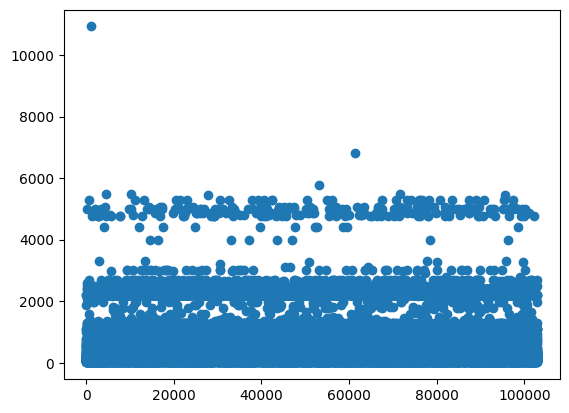

In [ ]:
#原因特定のため、可視化する
import matplotlib.pyplot as plt
plt.scatter(df3['rank'],df3['amount'])

In [ ]:
df3.sort_values(by='rank',ascending = True)

,sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount,rank
0,20181103,1541203200,S14006,112,1,CS006214000001,P070305012,1,158,1
1,20181118,1542499200,S13008,1132,2,CS008415000097,P070701017,1,81,2
2,20170712,1499817600,S14028,1102,1,CS028414000014,P060101005,1,170,3
3,20190205,1549324800,S14042,1132,1,ZZ000000000000,P050301001,1,25,4
4,20180821,1534809600,S14025,1102,2,CS025415000050,P060102007,1,90,5
...,...,...,...,...,...,...,...,...,...,...
104676,20180221,1519171200,S13043,1132,2,ZZ000000000000,P050101001,1,40,102911
104677,20190911,1568160000,S14047,1132,2,ZZ000000000000,P071006005,1,218,102912
104678,20170311,1489190400,S14040,1122,1,CS040513000195,P050405003,1,168,102913
104680,20190423,1555977600,S13016,1102,2,ZZ000000000000,P050601001,1,138,102914


In [ ]:
#結合時に誤った場所にrankが結合される。インデックスを初期化し忘れていたことが原因。
#データ結合時にインデックスを初期化しておかないと不具合が起きる場合がある。
df2.reset_index(drop=True, inplace=True)
rank_data.reset_index(drop=True, inplace=True)
df3 = pd.concat([df2,rank_data], axis=1)
A = df3[['customer_id', 'amount', 'rank']]
A.head(10)

,customer_id,amount,rank
0,CS011415000006,10925,1
1,ZZ000000000000,6800,2
2,CS028605000002,5780,3
3,ZZ000000000000,5480,4
4,CS015515000034,5480,5
5,ZZ000000000000,5480,6
6,ZZ000000000000,5440,7
7,CS021515000089,5440,8
8,CS008513000063,5280,9
9,CS032414000072,5280,10


---
> P-020: レシート明細データ（df_receipt）に対し、1件あたりの売上金額（amount）が高い順にランクを付与し、先頭から10件表示せよ。項目は顧客ID（customer_id）、売上金額（amount）、付与したランクを表示させること。なお、売上金額（amount）が等しい場合でも別順位を付与すること。

In [ ]:
df = df_receipt
#amount順にソート降順
df2 = df.sort_values(by='amount',ascending = False)
# ランクを初期化
rank = 1
rank_list = []
# データフレームの行をループ
for i in range(len(df2)-1):
    x = df.iloc[i, 8]
    y = df.iloc[i + 1, 8]
    rank_list.append(rank)
    rank += 1
rank_list.append(rank_list[-1])
print(len(rank_list))
#データフレームに変換して結合
rank_data=pd.DataFrame(rank_list, columns = ['rank'])
rank_data.reset_index(drop=True, inplace = True)
df2.reset_index(drop=True, inplace = True)
df3 = pd.concat([df2,rank_data], axis=1)
A = df3[['customer_id', 'amount', 'rank']]
A.head(10)

104681


,customer_id,amount,rank
0,CS011415000006,10925,1
1,ZZ000000000000,6800,2
2,CS028605000002,5780,3
3,ZZ000000000000,5480,4
4,CS015515000034,5480,5
5,ZZ000000000000,5480,6
6,ZZ000000000000,5440,7
7,CS021515000089,5440,8
8,CS008513000063,5280,9
9,CS032414000072,5280,10


---
> P-021: レシート明細データ（df_receipt）に対し、件数をカウントせよ。

In [ ]:
df_receipt.count()

sales_ymd         104681
sales_epoch       104681
store_cd          104681
receipt_no        104681
receipt_sub_no    104681
customer_id       104681
product_cd        104681
quantity          104681
amount            104681
dtype: int64

---
> P-022: レシート明細データ（df_receipt）の顧客ID（customer_id）に対し、ユニーク件数をカウントせよ。

In [ ]:
df = df_receipt
df['customer_id'].nunique()

8307

---
> P-023: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）と売上数量（quantity）を合計せよ。

In [ ]:
df2 = df[['store_cd', 'amount', 'quantity']].groupby('store_cd').count().unstack()
df2

          store_cd
amount    S12007      2076
          S12013      2385
          S12014      2333
          S12029      2518
          S12030      2372
                      ... 
quantity  S14046      1335
          S14047      1025
          S14048       760
          S14049       775
          S14050       575
Length: 104, dtype: int64

---
> P-024: レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに最も新しい売上年月日（sales_ymd）を求め、10件表示せよ。

In [ ]:
df2 = df[['customer_id','sales_ymd']].sort_values(by='sales_ymd', ascending=True)
#顧客id毎に集計して、アプライメソッドを適用しリストに格納。10件表示
grouped_df2 = df2.groupby('customer_id')['sales_ymd'].apply(list)
grouped_df2 = grouped_df2.reset_index()
grouped_df2.iloc[0:10, :]

,customer_id,sales_ymd
0,CS001113000004,"[20190308, 20190308]"
1,CS001114000005,"[20180503, 20180503, 20190731, 20190731]"
2,CS001115000010,"[20171228, 20171228, 20180701, 20180701, 20190..."
3,CS001205000004,"[20170914, 20170914, 20180821, 20180821, 20180..."
4,CS001205000006,"[20180207, 20180207, 20180415, 20180415, 20180..."
5,CS001211000025,"[20190322, 20190322]"
6,CS001212000027,"[20170127, 20170127]"
7,CS001212000031,"[20180906, 20180906]"
8,CS001212000046,"[20170811, 20170811]"
9,CS001212000070,"[20191018, 20191018]"


---
> P-025: レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに最も古い売上年月日（sales_ymd）を求め、10件表示せよ。

In [ ]:
#ascendingをFalseで指定
df2 = df[['customer_id','sales_ymd']].sort_values(by='sales_ymd', ascending=False)
#顧客id毎に集計して、アプライメソッドを適用しリストに格納。10件表示
grouped_df2 = df2.groupby('customer_id')['sales_ymd'].apply(list)
grouped_df2 = grouped_df2.reset_index()
grouped_df2.iloc[0:10, :]

,customer_id,sales_ymd
0,CS001113000004,"[20190308, 20190308]"
1,CS001114000005,"[20190731, 20190731, 20180503, 20180503]"
2,CS001115000010,"[20190405, 20190405, 20180701, 20180701, 20171..."
3,CS001205000004,"[20190625, 20190625, 20190312, 20190312, 20180..."
4,CS001205000006,"[20190224, 20190224, 20180616, 20180616, 20180..."
5,CS001211000025,"[20190322, 20190322]"
6,CS001212000027,"[20170127, 20170127]"
7,CS001212000031,"[20180906, 20180906]"
8,CS001212000046,"[20170811, 20170811]"
9,CS001212000070,"[20191018, 20191018]"


---
> P-026: レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに最も新しい売上年月日（sales_ymd）と古い売上年月日を求め、両者が異なるデータを10件表示せよ。

In [ ]:
df_new = df[['customer_id','sales_ymd']].sort_values(by='sales_ymd', ascending=True)
#顧客id毎に集計して、アプライメソッドを適用しリストに格納。
grouped_df_new = df_new.groupby('customer_id')['sales_ymd'].apply(list)
grouped_df_new = grouped_df_new.reset_index()
#ascendingをFalseで指定
df_old = df[['customer_id','sales_ymd']].sort_values(by='sales_ymd', ascending=False)
#顧客id毎に集計して、アプライメソッドを適用しリストに格納。
grouped_df_old = df_old.groupby('customer_id')['sales_ymd'].apply(list)
grouped_df_old = grouped_df_old.reset_index()
#loc関数に渡す条件式を作成
condition = grouped_df_old['sales_ymd'] == grouped_df_new['sales_ymd']
#~否定演算子で条件式を否定
selected_rows = grouped_df_new.loc[~condition].reset_index(drop=True)
selected_rows.iloc[0:10, :]

,customer_id,sales_ymd
0,CS001114000005,"[20180503, 20180503, 20190731, 20190731]"
1,CS001115000010,"[20171228, 20171228, 20180701, 20180701, 20190..."
2,CS001205000004,"[20170914, 20170914, 20180821, 20180821, 20180..."
3,CS001205000006,"[20180207, 20180207, 20180415, 20180415, 20180..."
4,CS001214000009,"[20170306, 20170306, 20170601, 20170601, 20170..."
5,CS001214000017,"[20180828, 20180828, 20180905, 20180905, 20181..."
6,CS001214000048,"[20171109, 20171109, 20180617, 20180617, 20190..."
7,CS001214000052,"[20180208, 20180208, 20180331, 20180331, 20190..."
8,CS001215000005,"[20170206, 20170206, 20180514, 20180514, 20181..."
9,CS001215000040,"[20170214, 20170214, 20170219, 20170219, 20170..."


---
> P-027: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の平均を計算し、降順でTOP5を表示せよ。

---
> P-028: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の中央値を計算し、降順でTOP5を表示せよ。

---
> P-029: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに商品コード（product_cd）の最頻値を求め、10件表示させよ。

---
> P-030: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の分散を計算し、降順で5件表示せよ。

---
> P-031: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の標準偏差を計算し、降順で5件表示せよ。

TIPS:

PandasとNumpyでddofのデフォルト値が異なることに注意しましょう
```
Pandas：
DataFrame.std(self, axis=None, skipna=None, level=None, ddof=1, numeric_only=None, **kwargs)
Numpy:
numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=)
```

---
> P-032: レシート明細データ（df_receipt）の売上金額（amount）について、25％刻みでパーセンタイル値を求めよ。

---
> P-033: レシート明細データ（df_receipt）に対し、店舗コード（store_cd）ごとに売上金額（amount）の平均を計算し、330以上のものを抽出せよ。

---
> P-034: レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに売上金額（amount）を合計して全顧客の平均を求めよ。ただし、顧客IDが"Z"から始まるものは非会員を表すため、除外して計算すること。

---
> P-035: レシート明細データ（df_receipt）に対し、顧客ID（customer_id）ごとに売上金額（amount）を合計して全顧客の平均を求め、平均以上に買い物をしている顧客を抽出し、10件表示せよ。ただし、顧客IDが"Z"から始まるものは非会員を表すため、除外して計算すること。

---
> P-036: レシート明細データ（df_receipt）と店舗データ（df_store）を内部結合し、レシート明細データの全項目と店舗データの店舗名（store_name）を10件表示せよ。

---
> P-037: 商品データ（df_product）とカテゴリデータ（df_category）を内部結合し、商品データの全項目とカテゴリデータのカテゴリ小区分名（category_small_name）を10件表示せよ。

---
> P-038: 顧客データ（df_customer）とレシート明細データ（df_receipt）から、顧客ごとの売上金額合計を求め、10件表示せよ。ただし、売上実績がない顧客については売上金額を0として表示させること。また、顧客は性別コード（gender_cd）が女性（1）であるものを対象とし、非会員（顧客IDが"Z"から始まるもの）は除外すること。

---
> P-039: レシート明細データ（df_receipt）から、売上日数の多い顧客の上位20件を抽出したデータと、売上金額合計の多い顧客の上位20件を抽出したデータをそれぞれ作成し、さらにその2つを完全外部結合せよ。ただし、非会員（顧客IDが"Z"から始まるもの）は除外すること。

---
> P-040: 全ての店舗と全ての商品を組み合わせたデータを作成したい。店舗データ（df_store）と商品データ（df_product）を直積し、件数を計算せよ。

---
> P-041: レシート明細データ（df_receipt）の売上金額（amount）を日付（sales_ymd）ごとに集計し、前回売上があった日からの売上金額増減を計算せよ。そして結果を10件表示せよ。

---
> P-042: レシート明細データ（df_receipt）の売上金額（amount）を日付（sales_ymd）ごとに集計し、各日付のデータに対し、前回、前々回、3回前に売上があった日のデータを結合せよ。そして結果を10件表示せよ。

---
> P-043： レシート明細データ（df_receipt）と顧客データ（df_customer）を結合し、性別コード（gender_cd）と年代（ageから計算）ごとに売上金額（amount）を合計した売上サマリデータを作成せよ。性別コードは0が男性、1が女性、9が不明を表すものとする。
>
> ただし、項目構成は年代、女性の売上金額、男性の売上金額、性別不明の売上金額の4項目とすること（縦に年代、横に性別のクロス集計）。また、年代は10歳ごとの階級とすること。

---
> P-044： 043で作成した売上サマリデータ（df_sales_summary）は性別の売上を横持ちさせたものであった。このデータから性別を縦持ちさせ、年代、性別コード、売上金額の3項目に変換せよ。ただし、性別コードは男性を"00"、女性を"01"、不明を"99"とする。

---
> P-045: 顧客データ（df_customer）の生年月日（birth_day）は日付型でデータを保有している。これをYYYYMMDD形式の文字列に変換し、顧客ID（customer_id）とともに10件表示せよ。

---
> P-046: 顧客データ（df_customer）の申し込み日（application_date）はYYYYMMDD形式の文字列型でデータを保有している。これを日付型に変換し、顧客ID（customer_id）とともに10件表示せよ。

---
> P-047: レシート明細データ（df_receipt）の売上日（sales_ymd）はYYYYMMDD形式の数値型でデータを保有している。これを日付型に変換し、レシート番号（receipt_no）、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。

---
> P-048: レシート明細データ（df_receipt）の売上エポック秒（sales_epoch）は数値型のUNIX秒でデータを保有している。これを日付型に変換し、レシート番号(receipt_no)、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。

---
> P-049: レシート明細データ（df_receipt）の売上エポック秒（sales_epoch）を日付型に変換し、「年」だけ取り出してレシート番号(receipt_no)、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。

---
> P-050: レシート明細データ（df_receipt）の売上エポック秒（sales_epoch）を日付型に変換し、「月」だけ取り出してレシート番号(receipt_no)、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。なお、「月」は0埋め2桁で取り出すこと。

---
> P-051: レシート明細データ（df_receipt）の売上エポック秒を日付型に変換し、「日」だけ取り出してレシート番号(receipt_no)、レシートサブ番号（receipt_sub_no）とともに10件表示せよ。なお、「日」は0埋め2桁で取り出すこと。

---
> P-052: レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計の上、売上金額合計に対して2,000円以下を0、2,000円より大きい金額を1に二値化し、顧客ID、売上金額合計とともに10件表示せよ。ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

---
> P-053: 顧客データ（df_customer）の郵便番号（postal_cd）に対し、東京（先頭3桁が100〜209のもの）を1、それ以外のものを0に二値化せよ。さらにレシート明細データ（df_receipt）と結合し、全期間において売上実績のある顧客数を、作成した二値ごとにカウントせよ。

---
> P-054: 顧客データ（df_customer）の住所（address）は、埼玉県、千葉県、東京都、神奈川県のいずれかとなっている。都道府県毎にコード値を作成し、顧客ID、住所とともに10件表示せよ。値は埼玉県を11、千葉県を12、東京都を13、神奈川県を14とすること。

---
> P-055: レシート明細（df_receipt）データの売上金額（amount）を顧客ID（customer_id）ごとに合計し、その合計金額の四分位点を求めよ。その上で、顧客ごとの売上金額合計に対して以下の基準でカテゴリ値を作成し、顧客ID、売上金額合計とともに10件表示せよ。カテゴリ値は順に1〜4とする。
>
> - 最小値以上第1四分位未満 ・・・ 1を付与
> - 第1四分位以上第2四分位未満 ・・・ 2を付与
> - 第2四分位以上第3四分位未満 ・・・ 3を付与
> - 第3四分位以上 ・・・ 4を付与

---
> P-056: 顧客データ（df_customer）の年齢（age）をもとに10歳刻みで年代を算出し、顧客ID（customer_id）、生年月日（birth_day）とともに10件表示せよ。ただし、60歳以上は全て60歳代とすること。年代を表すカテゴリ名は任意とする。

---
> P-057: 056の抽出結果と性別コード（gender_cd）により、新たに性別×年代の組み合わせを表すカテゴリデータを作成し、10件表示せよ。組み合わせを表すカテゴリの値は任意とする。

---
> P-058: 顧客データ（df_customer）の性別コード（gender_cd）をダミー変数化し、顧客ID（customer_id）とともに10件表示せよ。

---
> P-059: レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計し、売上金額合計を平均0、標準偏差1に標準化して顧客ID、売上金額合計とともに10件表示せよ。標準化に使用する標準偏差は、分散の平方根、もしくは不偏分散の平方根のどちらでも良いものとする。ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

TIPS:
- query()の引数engineで'python'か'numexpr'かを選択でき、デフォルトはインストールされていればnumexprが、無ければpythonが使われます。さらに、文字列メソッドはengine='python'でないとquery()内で使えません。


---
> P-060: レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計し、売上金額合計を最小値0、最大値1に正規化して顧客ID、売上金額合計とともに10件表示せよ。ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

---
> P-061: レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計し、売上金額合計を常用対数化（底10）して顧客ID、売上金額合計とともに10件表示せよ。ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

---
> P-062: レシート明細データ（df_receipt）の売上金額（amount）を顧客ID（customer_id）ごとに合計し、売上金額合計を自然対数化（底e）して顧客ID、売上金額合計とともに10件表示せよ。ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。

---
> P-063: 商品データ（df_product）の単価（unit_price）と原価（unit_cost）から各商品の利益額を算出し、結果を10件表示せよ。

---
> P-064: 商品データ（df_product）の単価（unit_price）と原価（unit_cost）から、各商品の利益率の全体平均を算出せよ。ただし、単価と原価には欠損が生じていることに注意せよ。

---
> P-065: 商品データ（df_product）の各商品について、利益率が30%となる新たな単価を求めよ。ただし、1円未満は切り捨てること。そして結果を10件表示させ、利益率がおよそ30％付近であることを確認せよ。ただし、単価（unit_price）と原価（unit_cost）には欠損が生じていることに注意せよ。

---
> P-066: 商品データ（df_product）の各商品について、利益率が30%となる新たな単価を求めよ。今回は、1円未満を丸めること（四捨五入または偶数への丸めで良い）。そして結果を10件表示させ、利益率がおよそ30％付近であることを確認せよ。ただし、単価（unit_price）と原価（unit_cost）には欠損が生じていることに注意せよ。

---
> P-067: 商品データ（df_product）の各商品について、利益率が30%となる新たな単価を求めよ。今回は、1円未満を切り上げること。そして結果を10件表示させ、利益率がおよそ30％付近であることを確認せよ。ただし、単価（unit_price）と原価（unit_cost）には欠損が生じていることに注意せよ。

---
> P-068: 商品データ（df_product）の各商品について、消費税率10％の税込み金額を求めよ。1円未満の端数は切り捨てとし、結果を10件表示せよ。ただし、単価（unit_price）には欠損が生じていることに注意せよ。

---
> P-069: レシート明細データ（df_receipt）と商品データ（df_product）を結合し、顧客毎に全商品の売上金額合計と、カテゴリ大区分コード（category_major_cd）が"07"（瓶詰缶詰）の売上金額合計を計算の上、両者の比率を求めよ。抽出対象はカテゴリ大区分コード"07"（瓶詰缶詰）の売上実績がある顧客のみとし、結果を10件表示せよ。

---
> P-070: レシート明細データ（df_receipt）の売上日（sales_ymd）に対し、顧客データ（df_customer）の会員申込日（application_date）からの経過日数を計算し、顧客ID（customer_id）、売上日、会員申込日とともに10件表示せよ（sales_ymdは数値、application_dateは文字列でデータを保持している点に注意）。

---
> P-071: レシート明細データ（df_receipt）の売上日（sales_ymd）に対し、顧客データ（df_customer）の会員申込日（application_date）からの経過月数を計算し、顧客ID（customer_id）、売上日、会員申込日とともに10件表示せよ（sales_ymdは数値、application_dateは文字列でデータを保持している点に注意）。1ヶ月未満は切り捨てること。

---
> P-072: レシート明細データ（df_receipt）の売上日（df_customer）に対し、顧客データ（df_customer）の会員申込日（application_date）からの経過年数を計算し、顧客ID（customer_id）、売上日、会員申込日とともに10件表示せよ（sales_ymdは数値、application_dateは文字列でデータを保持している点に注意）。1年未満は切り捨てること。

---
> P-073: レシート明細データ（df_receipt）の売上日（sales_ymd）に対し、顧客データ（df_customer）の会員申込日（application_date）からのエポック秒による経過時間を計算し、顧客ID（customer_id）、売上日、会員申込日とともに10件表示せよ（なお、sales_ymdは数値、application_dateは文字列でデータを保持している点に注意）。なお、時間情報は保有していないため各日付は0時0分0秒を表すものとする。

---
> P-074: レシート明細データ（df_receipt）の売上日（sales_ymd）に対し、当該週の月曜日からの経過日数を計算し、売上日、直前の月曜日付とともに10件表示せよ（sales_ymdは数値でデータを保持している点に注意）。

---
> P-075: 顧客データ（df_customer）からランダムに1%のデータを抽出し、先頭から10件表示せよ。

---
> P-076: 顧客データ（df_customer）から性別コード（gender_cd）の割合に基づきランダムに10%のデータを層化抽出し、性別コードごとに件数を集計せよ。

---
> P-077: レシート明細データ（df_receipt）の売上金額を顧客単位に合計し、合計した売上金額の外れ値を抽出せよ。なお、外れ値は売上金額合計を対数化したうえで平均と標準偏差を計算し、その平均から3σを超えて離れたものとする（自然対数と常用対数のどちらでも可）。結果は10件表示せよ。

---
> P-078: レシート明細データ（df_receipt）の売上金額（amount）を顧客単位に合計し、合計した売上金額の外れ値を抽出せよ。ただし、顧客IDが"Z"から始まるのものは非会員を表すため、除外して計算すること。なお、ここでは外れ値を第1四分位と第3四分位の差であるIQRを用いて、「第1四分位数-1.5×IQR」を下回るもの、または「第3四分位数+1.5×IQR」を超えるものとする。結果は10件表示せよ。

---
> P-079: 商品データ（df_product）の各項目に対し、欠損数を確認せよ。

---
> P-080: 商品データ（df_product）のいずれかの項目に欠損が発生しているレコードを全て削除した新たな商品データを作成せよ。なお、削除前後の件数を表示させ、079で確認した件数だけ減少していることも確認すること。

---
> P-081: 単価（unit_price）と原価（unit_cost）の欠損値について、それぞれの平均値で補完した新たな商品データを作成せよ。なお、平均値については1円未満を丸めること（四捨五入または偶数への丸めで良い）。補完実施後、各項目について欠損が生じていないことも確認すること。

---
> P-082: 単価（unit_price）と原価（unit_cost）の欠損値について、それぞれの中央値で補完した新たな商品データを作成せよ。なお、中央値については1円未満を丸めること（四捨五入または偶数への丸めで良い）。補完実施後、各項目について欠損が生じていないことも確認すること。

---
> P-083: 単価（unit_price）と原価（unit_cost）の欠損値について、各商品のカテゴリ小区分コード（category_small_cd）ごとに算出した中央値で補完した新たな商品データを作成せよ。なお、中央値については1円未満を丸めること（四捨五入または偶数への丸めで良い）。補完実施後、各項目について欠損が生じていないことも確認すること。

---
> P-084: 顧客データ（df_customer）の全顧客に対して全期間の売上金額に占める2019年売上金額の割合を計算し、新たなデータを作成せよ。ただし、売上実績がない場合は0として扱うこと。そして計算した割合が0超のものを抽出し、結果を10件表示せよ。また、作成したデータに欠損が存在しないことを確認せよ。

---
> P-085: 顧客データ（df_customer）の全顧客に対し、郵便番号（postal_cd）を用いてジオコードデータ（df_geocode）を紐付け、新たな顧客データを作成せよ。ただし、1つの郵便番号（postal_cd）に複数の経度（longitude）、緯度（latitude）情報が紐づく場合は、経度（longitude）、緯度（latitude）の平均値を算出して使用すること。また、作成結果を確認するために結果を10件表示せよ。

---
> P-086: 085で作成した緯度経度つき顧客データに対し、会員申込店舗コード（application_store_cd）をキーに店舗データ（df_store）と結合せよ。そして申込み店舗の緯度（latitude）・経度情報（longitude)と顧客住所（address）の緯度・経度を用いて申込み店舗と顧客住所の距離（単位：km）を求め、顧客ID（customer_id）、顧客住所（address）、店舗住所（address）とともに表示せよ。計算式は以下の簡易式で良いものとするが、その他精度の高い方式を利用したライブラリを利用してもかまわない。結果は10件表示せよ。

$$
\mbox{緯度（ラジアン）}：\phi \\
\mbox{経度（ラジアン）}：\lambda \\
\mbox{距離}L = 6371 * \arccos(\sin \phi_1 * \sin \phi_2
+ \cos \phi_1 * \cos \phi_2 * \cos(\lambda_1 − \lambda_2))
$$

---
> P-087: 顧客データ（df_customer）では、異なる店舗での申込みなどにより同一顧客が複数登録されている。名前（customer_name）と郵便番号（postal_cd）が同じ顧客は同一顧客とみなして1顧客1レコードとなるように名寄せした名寄顧客データを作成し、顧客データの件数、名寄顧客データの件数、重複数を算出せよ。ただし、同一顧客に対しては売上金額合計が最も高いものを残し、売上金額合計が同一もしくは売上実績がない顧客については顧客ID（customer_id）の番号が小さいものを残すこととする。

---
> P-088: 087で作成したデータを元に、顧客データに統合名寄IDを付与したデータを作成せよ。ただし、統合名寄IDは以下の仕様で付与するものとする。
>
> - 重複していない顧客：顧客ID（customer_id）を設定
> - 重複している顧客：前設問で抽出したレコードの顧客IDを設定
>
> 顧客IDのユニーク件数と、統合名寄IDのユニーク件数の差も確認すること。

---
> P-089: 売上実績がある顧客を、予測モデル構築のため学習用データとテスト用データに分割したい。それぞれ8:2の割合でランダムにデータを分割せよ。

---
> P-090: レシート明細データ（df_receipt）は2017年1月1日〜2019年10月31日までのデータを有している。売上金額（amount）を月次で集計し、学習用に12ヶ月、テスト用に6ヶ月の時系列モデル構築用データを3セット作成せよ。

---
> P-091: 顧客データ（df_customer）の各顧客に対し、売上実績がある顧客数と売上実績がない顧客数が1:1となるようにアンダーサンプリングで抽出せよ。

---
> P-092: 顧客データ（df_customer）の性別について、第三正規形へと正規化せよ。

---
> P-093: 商品データ（df_product）では各カテゴリのコード値だけを保有し、カテゴリ名は保有していない。カテゴリデータ（df_category）と組み合わせて非正規化し、カテゴリ名を保有した新たな商品データを作成せよ。

---
> P-094: 093で作成したカテゴリ名付き商品データを以下の仕様でファイル出力せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |CSV（カンマ区切り）|有り|UTF-8|
>
> ファイル出力先のパスは以下のようにすること
>
> |出力先|
> |:--:|
> |./data|

---
> P-095: 093で作成したカテゴリ名付き商品データを以下の仕様でファイル出力せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |CSV（カンマ区切り）|有り|CP932|
>
> ファイル出力先のパスは以下のようにすること。
>
> |出力先|
> |:--:|
> |./data|

---
> P-096: 093で作成したカテゴリ名付き商品データを以下の仕様でファイル出力せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |CSV（カンマ区切り）|無し|UTF-8|
>
> ファイル出力先のパスは以下のようにすること。
>
> |出力先|
> |:--:|
> |./data|

---
> P-097: 094で作成した以下形式のファイルを読み込み、データを3件を表示させて正しく取り込まれていることを確認せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |CSV（カンマ区切り）|有り|UTF-8|

---
> P-098: 096で作成した以下形式のファイルを読み込み、データを3件を表示させて正しく取り込まれていることを確認せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |CSV（カンマ区切り）|ヘッダ無し|UTF-8|

---
> P-099: 093で作成したカテゴリ名付き商品データを以下の仕様でファイル出力せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |TSV（タブ区切り）|有り|UTF-8|
>
> ファイル出力先のパスは以下のようにすること
>
> |出力先|
> |:--:|
> |./data|

---
> P-100: 099で作成した以下形式のファイルを読み込み、データを3件を表示させて正しく取り込まれていることを確認せよ。
>
> |ファイル形式|ヘッダ有無|文字エンコーディング|
> |:--:|:--:|:--:|
> |TSV（タブ区切り）|有り|UTF-8|

# これで１００本終わりです。おつかれさまでした！